In [1]:
import h5py
import sys
from scipy import constants as sp
import os

from numba import njit, prange

sys.path.append('..')

from solver import solver
from analyzer import analyzer
from integrators import relativistic_boris

from fields import *
from distributions import *

Load IGRF coefficients ...


In [2]:
e_field = zero_field()
b_field = t89(7)
s = solver(e_field, b_field, drop_lost=True)

In [3]:
s.populate_by_eq_pa(100,
                    10,
                    delta(1e6),
                    uniform(np.radians(0), np.radians(90)),
                    uniform(0, 2 * np.pi)
                   )

100%|██████████| 100/100 [00:02<00:00, 46.04it/s]


In [5]:
s.solve(2, 1e-4, 1e-3)

100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


In [9]:
s.save('../simulations/test')

../simulations/test already exists. Overwrite? (Y/N) Y
Saved file ../simulations/test.hdf5 containing 928.03 megabytes of information.


In [64]:
def diff(quantity, time, delta_t, bins=100):
    dt = np.abs(time[1] - time[0])
    delta_t_ind = int(max(delta_t // dt, 1))
    
    steps = np.shape(quantity)[1]
    
    beg = quantity
    end = np.roll(quantity, -delta_t_ind, axis=1)
    end[:, -delta_t_ind:] = beg[:, -delta_t_ind:]

    ind_diff_coef = (end - beg)**2 / (2 * delta_t_ind * dt)
    
    max_val = np.amax(quantity)
    bin_width = max_val / (bins - 1)
    binned_quantity = (quantity // bin_width).astype(int)
    
    bin_array = np.linspace(0, max_val, bins)
    
    unweighted_diff_coef = np.zeros((bins, steps))
    weights = np.zeros((bins, steps))

    for i in range(steps):
        np.add.at(unweighted_diff_coef[:, i], binned_quantity[:, i], ind_diff_coef[:, i])
        np.add.at(weights[:, i], binned_quantity[:, i], 1)
        
    diff_coef = np.divide(unweighted_diff_coef, weights, out=np.zeros_like(unweighted_diff_coef), where=weights != 0)
    
    return bin_array, diff_coef

(0.0, 1684.6603519500425)

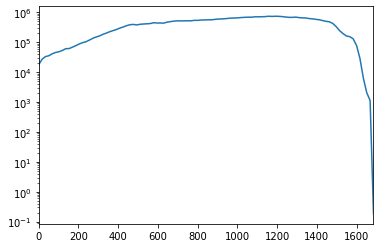

In [11]:
bin_array, final_duus = a.moment_diff(1e-1)
plt.semilogy(bin_array, np.mean(final_duus[:, :1800], axis=1))
plt.xlim([bin_array[0], bin_array[-1]])

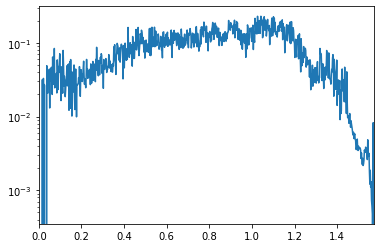

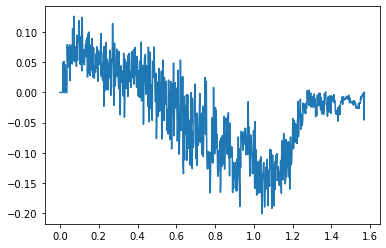

In [41]:
ar, df = diff_numba(a.eq_pitch_ang(), a.time(), 2e-1, 800)
ar, tf = transport_numba(a.eq_pitch_ang(), a.time(), 2e-1, 800)
plt.semilogy(ar, np.mean(df[:, 500:1500], axis=1))
plt.xlim([ar[0], ar[-1]])
plt.show()
plt.plot(ar, np.mean(tf[:, 500:1500], axis=1))

In [3]:
@njit
def lost_ind(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])
    
    zero_array = np.zeros((4, 3))
    index_list = np.zeros(num_particles) + steps

    for i in range(num_particles):
        for j in range(steps):
            if (history[i, -(j + 1), :, :] == zero_array).all():
                index_list[i] -= 1
            else:
                break

    return index_list

ind_list = lost_ind(history)

In [2]:
history = np.zeros((5000, 2000, 4, 3))
intrinsic = np.zeros((5000, 2))

history[:, :, 0, :] = a.position()
history[:, :, 1, :] = a.velocity()
history[:, :, 2, :] = a.magnetic_field()
history[:, :, 3, :] = a.electric_field()

intrinsic[:, 0] = a.mass()
intrinsic[:, 1] = a.charge()

moments = a.moment() / 6.242e8
mags = a.b_mag()

In [223]:
def ind_diff(quantity, time, delta_t):
    dt = time[1] - time[0]
    
    num_particles    = np.shape(quantity)[0]
    delta_t_ind      = int(max(delta_t // dt, 1))
    steps            = int(np.shape(quantity)[1] // delta_t_ind)

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))
    t_coef = np.zeros((num_particles, steps - 1))
    
    for i in range(num_particles):  
        for j in range(steps - 1): 
            if (j + 1) * delta_t_ind >= np.shape(quantity)[1] - 1:
                break
                
            mu_begin = quantity[i, j * delta_t_ind] #mom[i, j * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, j * delta_t_ind], v[i, j * delta_t_ind]))
            mu_end = quantity[i, (j + 1) * delta_t_ind] #mom[i, (j + 1) * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, (j + 1) * delta_t_ind], v[i, (j + 1) * delta_t_ind]))
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            
            mus[i, j]   = mu_begin
            t_coef[i, j] = mu_end - mu_begin
            
    return mus, D_uus, t_coef

In [4]:
from math import floor
import matplotlib.colors as color
from utils import dot

def per_particle_mu_diffusion(quantity, delta_t, dt):
    num_particles    = np.shape(quantity)[0]
    delta_t_ind      = int(max(delta_t // dt, 1))
    steps            = int(np.shape(quantity)[1] // delta_t_ind)
    
    beg = quantity
    end = np.roll(quantity, -delta_t_ind, axis=1)
    end[:, -delta_t_ind:] = beg[:, -delta_t_ind:]

    ind_diff_coef = (end - beg)**2 / (2 * delta_t_ind * dt)
    t_coef_ind = end - beg
    
    mus = beg[:, ::delta_t_ind]
    D_uus = ind_diff_coef[:, ::delta_t_ind]
    t_coef = t_coef_ind[:, ::delta_t_ind]
            
    return mus, D_uus, t_coef

def D_mumu_evolution(quantity, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    
    num_particles    = np.shape(quantity)[0]
    delta_t_ind      = int(max(delta_t // dt, 1))
    steps            = int(np.shape(quantity)[1] // delta_t_ind)
    
    beg = quantity
    end = np.roll(quantity, -delta_t_ind, axis=1)
    end[:, -delta_t_ind:] = beg[:, -delta_t_ind:]

    ind_diff_coef = (end - beg)**2 / (2 * delta_t_ind * dt)
    t_coef_ind = end - beg
    
    mus = beg[:, ::delta_t_ind]
    D_uus = ind_diff_coef[:, ::delta_t_ind]
    t_coef = t_coef_ind[:, ::delta_t_ind]

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins - 1):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]
        
        bin_size = np.amax(mus) / v_bins
        
        for j in range(len(mus[:, i])):
            bin_ind = floor(mus[j, i] // bin_size)
            if bin_ind == v_bins:
                bin_ind -= 1
            D_uu_averaged[bin_ind].append(D_uus[j, i])
            t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
        
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)

        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))

    
    col = plt.cm.plasma(0.2)
    
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'
    
    fig = plt.figure(figsize=(12, 4.8))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma', norm=color.LogNorm(vmin=1e-16, vmax=1e-10))

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(180, 0, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
    plt.title(r'Diffusion coef.')
    
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$', rotation=-90, va="bottom")
    
    plt.subplot(1, 2, 2)
    plt.xlim([0, 180])
    plt.xticks(np.linspace(0, 180, 5))
    plt.xlabel(r'Eq. pitch angle $\alpha_0^\circ$')
    
    plt.ylim([1e-16, 1e-10])
    plt.yticks(np.logspace(-16, -10, 5))
    plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}(\alpha_0) \rangle$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    plt.semilogy(np.linspace(0, 180, v_bins), np.flip(np.mean(D_uu_map[:, -int(v_bins/3):], axis=1)), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    ax.plot(np.linspace(0, 180, v_bins), np.flip(np.mean(t_coef_map[:, -int(v_bins/3):], axis=1)), color=col)
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-40, 40, 5))
    plt.ylabel(r'$\langle\Delta\alpha_0\rangle$ (deg)', color=col)
    [i.set_color(col) for i in ax.get_yticklabels()]
    
    plt.title(r'Time average')
    
    plt.tight_layout(pad=2.0)
    plt.show()
    
    return mus, D_uus, t_coef

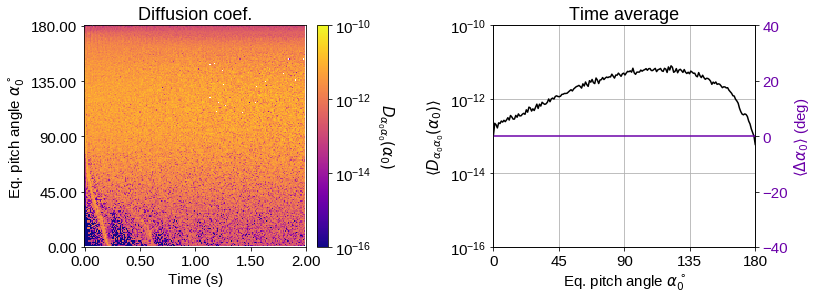

In [5]:
mus, duus, tcoefs = D_mumu_evolution(moments, 200, 200, 2, 1e-3)

In [10]:
bins = 200
bin_width = (np.amax(mus) - np.amin(mus)) / (bins - 1)
binned_mus = ((mus + np.amin(mus)) // bin_width).astype(int)

D_uus = np.zeros((bins, np.shape(a.time())[0]))

np.shape(D_uus)

#np.add.at(duus[:, 0], binned_mus[:, 0], duus[:, 0])

(200, 2000)

In [2]:
gca_results = gca(a.magnetic_field(), a.position(), a.velocity(), a.mass(), a.charge())

In [68]:
bb = a.magnetic_field()
vv = a.velocity()
rr = a.position()
mm = a.mass()
qq = a.charge()

b_dot_b = np.sum(bb**2, axis=2)
b_cross_v = np.cross(bb, vv, axis=2)

v_dot_v = np.sum(vv**2, axis=2)
gamma = 1.0 / np.sqrt(1.0 - v_dot_v / sp.c**2)
gamma_over_b_dot_b = np.divide(gamma, b_dot_b, out=np.zeros_like(gamma), where=b_dot_b != 0)

gca_v = rr - gamma_over_b_dot_b[:, :, np.newaxis] * mm[:, np.newaxis, np.newaxis] * b_cross_v / qq[:, np.newaxis, np.newaxis]

In [76]:
np.argwhere(np.abs(gca_results - gca_v) > 1e-8)

array([], shape=(0, 3), dtype=int64)

In [ ]:

num_particles = np.shape(position)[0]
steps         = np.shape(position)[1]

gca_v = np.zeros((num_particles, steps, 3))

for i in prange(num_particles):
    for j in prange(steps):
        b_dot_b = b_field[i, j, 0]**2 + b_field[i, j, 1]**2 + b_field[i, j, 2]**2
        if b_dot_b == 0:
            continue

        b_cross_v = np.zeros(3)
        b_cross_v[0] = b_field[i, j, 1] * velocity[i, j, 2] - b_field[i, j, 2] * velocity[i, j, 1]
        b_cross_v[1] = b_field[i, j, 2] * velocity[i, j, 0] - b_field[i, j, 0] * velocity[i, j, 2]
        b_cross_v[2] = b_field[i, j, 0] * velocity[i, j, 1] - b_field[i, j, 1] * velocity[i, j, 0]

        v_dot_v = velocity[i, j, 0]**2 + velocity[i, j, 1]**2 + velocity[i, j, 2]**2
        gamma = 1.0 / sqrt(1.0 - v_dot_v / sp.c**2)

        gca_v[i, j] = position[i, j] - gamma * mass[i] / (charge[i] * b_dot_b) * b_cross_v

return gca_v


In [6]:
@njit(parallel=True)
def b_along_gca(b_field, gca_results, time):
    num_particles = np.shape(gca_results)[0]
    steps = np.shape(gca_results)[1]

    b_along_gca_v = np.zeros((num_particles, steps, 3))
    
    for i in prange(num_particles):
        for j in prange(steps):
            if (gca_results[i, j] == 0).all():
                continue
                
            b_along_gca_v[i, j, :] = b_field(gca_results[i, j, :], time[j])

    return b_along_gca_v

In [6]:
a.moment_diff(2e-1, 100, numba=False, recalc=True)

(array([   0.        ,   17.01677123,   34.03354246,   51.0503137 ,
          68.06708493,   85.08385616,  102.10062739,  119.11739862,
         136.13416985,  153.15094109,  170.16771232,  187.18448355,
         204.20125478,  221.21802601,  238.23479725,  255.25156848,
         272.26833971,  289.28511094,  306.30188217,  323.3186534 ,
         340.33542464,  357.35219587,  374.3689671 ,  391.38573833,
         408.40250956,  425.4192808 ,  442.43605203,  459.45282326,
         476.46959449,  493.48636572,  510.50313695,  527.51990819,
         544.53667942,  561.55345065,  578.57022188,  595.58699311,
         612.60376435,  629.62053558,  646.63730681,  663.65407804,
         680.67084927,  697.6876205 ,  714.70439174,  731.72116297,
         748.7379342 ,  765.75470543,  782.77147666,  799.7882479 ,
         816.80501913,  833.82179036,  850.83856159,  867.85533282,
         884.87210405,  901.88887529,  918.90564652,  935.92241775,
         952.93918898,  969.95596021,  986.97273

In [2]:
a = np.array([[1, 2, 3],[4, 5, 6]])

In [5]:
a[a > 2] = 5 - a[a > 2]

In [6]:
a

array([[ 1,  2,  2],
       [ 1,  0, -1]])

In [6]:
a.eq_pitch_ang(b_field, recalc=True, unwrapped=True)

array([[1.45732966, 1.45732966, 1.45732966, ..., 1.78580144, 1.78580144,
        1.78580144],
       [1.16790917, 1.16790917, 1.16790917, ..., 2.70171587, 2.70171587,
        2.70171587],
       [0.89174058, 2.24985207, 2.24985207, ..., 0.26393952, 0.26393952,
        0.26393952],
       ...,
       [0.52719272, 0.52719272, 0.52719272, ..., 0.78278973, 0.78278973,
        0.78278973],
       [1.09791566, 1.09791566, 2.04367699, ..., 0.39063787, 0.39063787,
        0.39063787],
       [1.02413288, 1.02413288, 1.02413288, ..., 0.36884587, 0.36884587,
        0.36884587]])

In [13]:
bins, pas = a.moment_diff(delta_t=0.2, bins=150, numba=True, recalc=True)

(0.0, 1684.6603519500425)

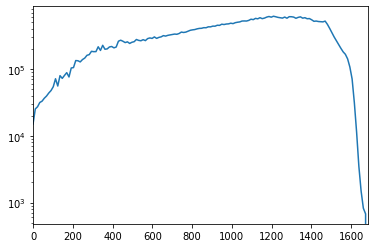

In [14]:
plt.semilogy(bins, np.mean(pas[:, 0:1800], axis=1))
plt.xlim([bins[0], bins[-1]])